<a href="https://colab.research.google.com/github/TeamMAMI/MAMI/blob/main/Baselines/image_text_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate baseline for image plus text data

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
requires the same folder:
- script evaluation
-folder 'ref' with truth.txt
-folder 'TRAINING' with images
'''

# import evaluation
import pandas as pd
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import regularizers
import os
import gc
import shutil 


In [4]:
# paths
csv_path_test = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Temporary/test.csv'
csv_path_train = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Temporary/train.csv'
image_path = '/content/drive/Shareddrives/team_MAMI/MAMI/TRAIN/Images'


def loadImage(image_path):
    try:
        return load_img(image_path, target_size=(image_size, image_size))
    except:
        image_path = image_path.replace('png', 'jpg')
        return load_img(image_path, target_size=(image_size, image_size))

if not os.path.exists('./ImageTextModel'):
    os.makedirs('./ImageTextModel')
    
batch_size = 32
epochs = 50
image_size = 224
embed_size = 512 #according to USE
threshold = 0.5

#Universal Sentence Encoder
tf.compat.v1.disable_eager_execution()

module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3?tf-hub-format=compressed"
embed = hub.Module(module_url)


In [5]:

#_______________________________Load Train Data_______________________________
train_df = pd.read_csv(csv_path_train, usecols=['file_name', 'misogynous', 'Text Transcription'])
path = image_path+'/'

train_df['image_path'] = path + train_df['file_name']

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(train_df, 10)
train_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()
      
train_df['USE'] = text_embeddings

#load images
train_df['image'] = None
train_df['image'] = train_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
X_train = train_df[['file_name', 'USE', 'image']]
y_train = train_df['misogynous']

#text
tmp = []
for value in X_train['USE']:
    tmp.append([value])  
tX_train = np.array(tmp)

#images
tmp = []
for value in X_train['image']:
  tmp.append(value) 
iX_train = np.array(tmp)

#misogynous label
tmp = []
for value in y_train:
    tmp.append([value])  
y_train = np.array(tmp)

#clear memory
del train_df
del dfs
del text_embedding
del text_embeddings

gc.collect()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0

In [6]:
#_______________________________IMAGE MODEL_______________________________
l2_strength = 1e-5

input_image = layers.Input(shape=(image_size,image_size,3))
vgg_model = VGG16(input_tensor = input_image, weights = 'imagenet', include_top=False)

for layer in vgg_model.layers:
    layer.trainable = False

x = vgg_model.output
x = layers.Flatten(input_shape=vgg_model.output_shape[1:])(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_strength))(x)
x = layers.Dense(1, activation='sigmoid')(x)
image_model = Model(vgg_model.input, x)

image_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
image_model.summary()

history = image_model.fit(iX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= epochs,
                    batch_size=batch_size,
                    #verbose=0,
                    )
                    
image_model.save('./ImageTextModel/image_model.h5')



58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6300/6300 [==============================] - 33s 5ms/sample - loss: 3.3793 - accuracy: 0.5717 - val_loss: 0.6908 - val_accuracy: 0.6229
Epoch 2/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 0.8265 - accuracy: 0.6221 - val_loss: 0.6673 - val_accuracy: 0.6514
Epoch 3/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 0.7103 - accuracy: 0.6497 - val_loss: 0.6208 - val_accuracy: 0.6714
Epoch 4/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 0.6578 - accuracy: 0.6456 - val_loss: 0.6310 - val_accuracy: 0.6643
Epoch 5/50
6300/6300 [==============================] - 16s 3ms/sample - loss: 0.6392 - accuracy: 0.6603 - val_loss: 0.6251 - val_accuracy: 0.6686
Epoch 6/50
6300/6300 [==============================] - 16s 3ms/sample - loss: 0.5993 - accuracy: 0.6738 - val_loss: 0.6566 - val_accuracy: 0.6214
Epoch 7/50
6300/6300 [==============================] - 16s 2ms/sample - loss: 0.5733 - accuracy: 0.6757 - val_loss: 0.6569 - val

In [7]:
#_______________________________TEXT MODEL_______________________________
input_text = layers.Input(shape=(1, embed_size))
l = layers.Dense(1, activation='sigmoid')(input_text)
text_model = Model(inputs=[input_text], outputs=l)
text_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
text_model.summary()

history = text_model.fit(tX_train, 
                    y_train,
                    validation_split=0.1,
                    epochs= epochs,
                    batch_size=batch_size,
                    #verbose=0
                    )

text_model.save('./ImageTextModel/text_model.h5')



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 512)]          0         
                                                                 
 dense_3 (Dense)             (None, 1, 1)              513       
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________
Train on 6300 samples, validate on 700 samples
Epoch 1/50
5984/6300 [===========================>..] - ETA: 0s - loss: 0.6938 - accuracy: 0.4967

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6300/6300 [==============================] - 2s 383us/sample - loss: 0.6938 - accuracy: 0.4964 - val_loss: 0.6932 - val_accuracy: 0.5039
Epoch 2/50
6300/6300 [==============================] - 0s 76us/sample - loss: 0.6934 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5031
Epoch 3/50
6300/6300 [==============================] - 0s 69us/sample - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6933 - val_accuracy: 0.5038
Epoch 4/50
6300/6300 [==============================] - 0s 73us/sample - loss: 0.6931 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5058
Epoch 5/50
6300/6300 [==============================] - 0s 73us/sample - loss: 0.6933 - accuracy: 0.5018 - val_loss: 0.6927 - val_accuracy: 0.5135
Epoch 6/50
6300/6300 [==============================] - 0s 71us/sample - loss: 0.6931 - accuracy: 0.5066 - val_loss: 0.6930 - val_accuracy: 0.5056
Epoch 7/50
6300/6300 [==============================] - 0s 71us/sample - loss: 0.6933 - accuracy: 0.5028 - val_loss: 0.6930 - va

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

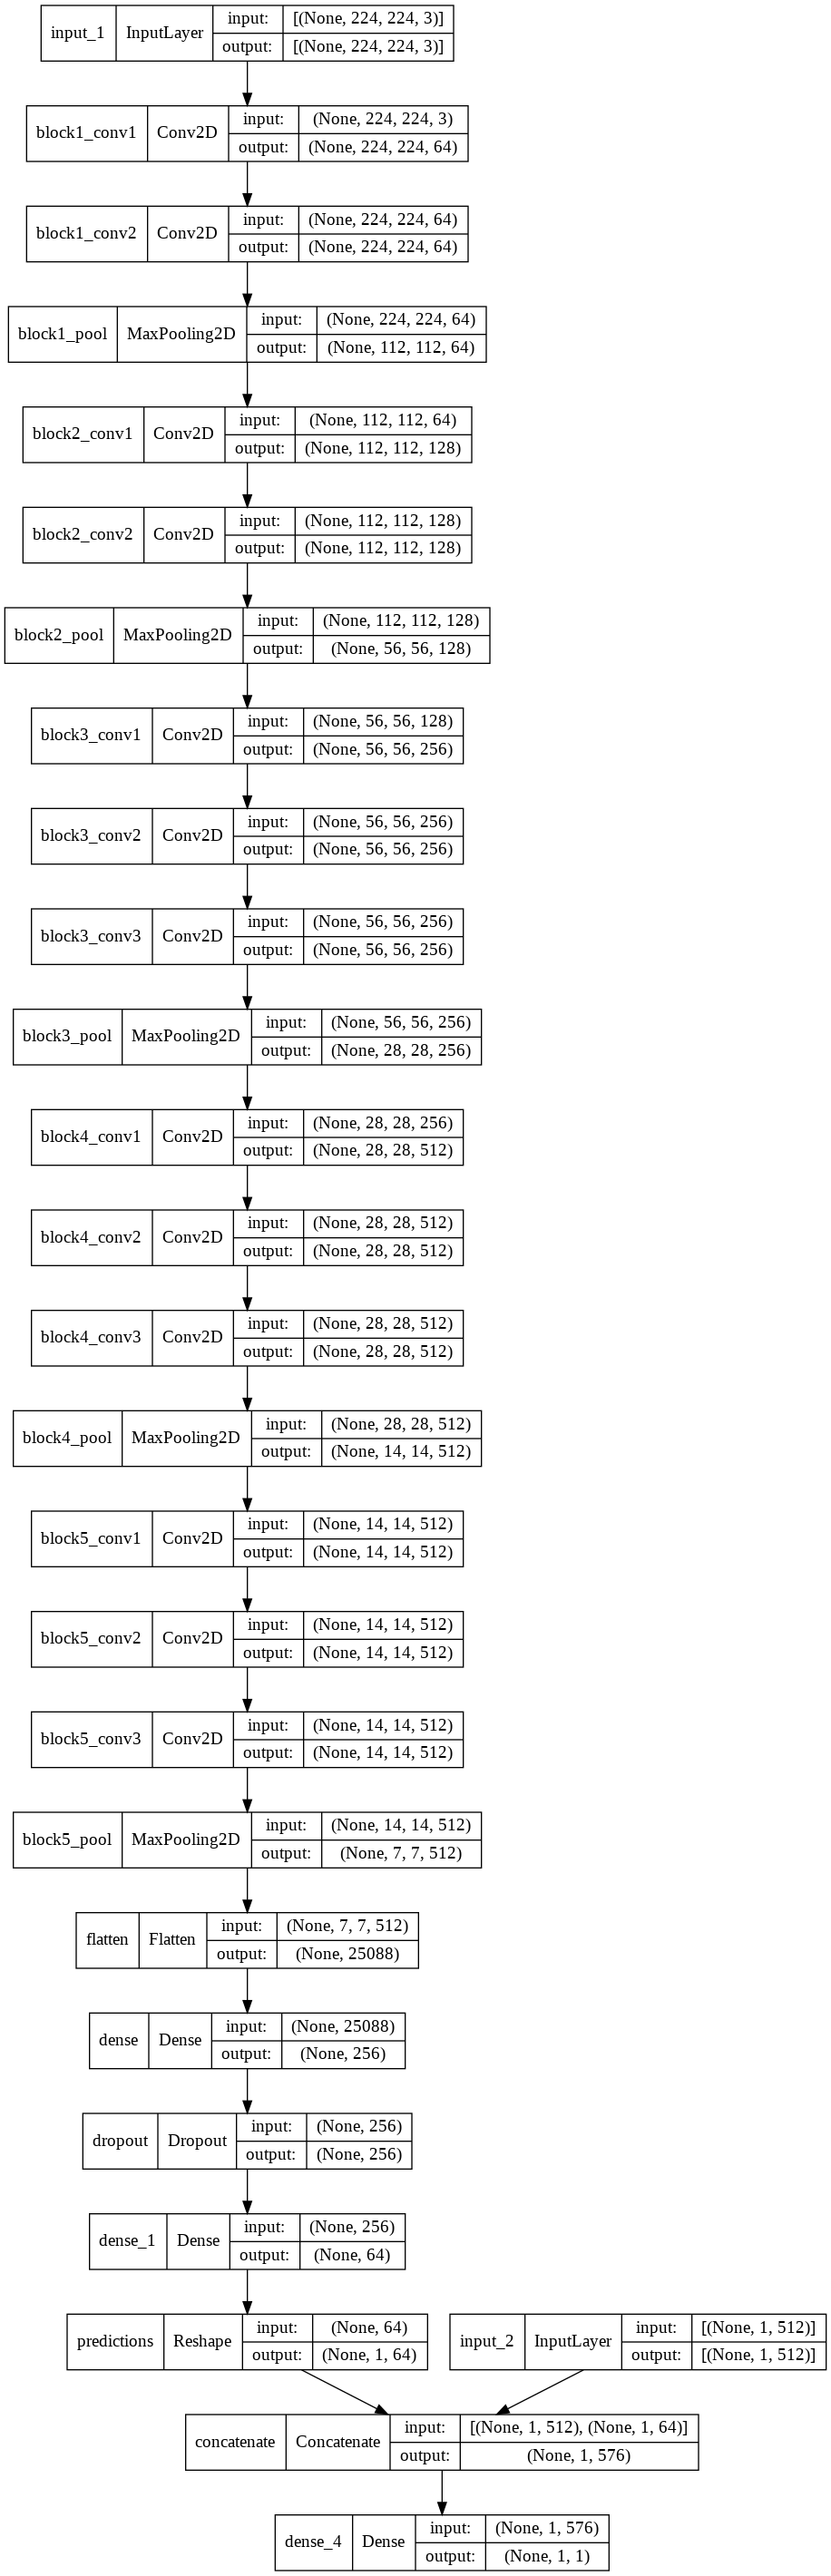

In [8]:
#_______________________________IMAGE-TEXT MODEL_______________________________
image = image_model.layers[len(image_model.layers)-2].output
reshape = layers.Reshape((1, image_model.layers[len(image_model.layers)-2].output_shape[1]), name='predictions')(image)
text = text_model.layers[0].output

input = tf.keras.layers.Concatenate(axis=-1)([text, reshape])

l = layers.Dense(1, activation='sigmoid')(input)
model = Model(inputs=[input_text, input_image], outputs=[l])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.save('./ImageTextModel/image_text_model.h5')
tf.keras.utils.plot_model(model, "./ImageTextModel/model.png", show_shapes=True)



In [9]:
#_______________________________Load Test Data_______________________________
#clear memory
del X_train
del y_train
del iX_train
del tX_train

gc.collect()

#load data
test_df = pd.read_csv(csv_path_test)
path = image_path+'/'
test_df['image_path'] = path + test_df['file_name']

# Universal Sentence Encoder (USE)
'''
Split the dataset to avoid hitting the USE call limit
an error occurs if the 47900 steps are reached
'''
dfs = np.array_split(test_df, 10)
test_df['USE'] = None
text_embeddings=[]
with tf.compat.v1.Session() as session:
    session.run([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
   
    for x in dfs:
      x_data_matches = pd.Series([])
      text_embedding = session.run(embed(list(x['Text Transcription'])))
      text_embeddings = text_embeddings + np.array(text_embedding).tolist()
test_df['USE'] = text_embeddings

#Load images
test_df['image'] = None
test_df['image'] = test_df['image_path'].apply(lambda x: img_to_array(loadImage(x)))        

#division and processing of data as input to the model
X_test = test_df[['file_name', 'USE', 'image']]

#Text
tmp = []
for value in X_test['USE']:
    tmp.append([value])  
tX_test = np.array(tmp)


#images
tmp = []
for value in X_test['image']:
    tmp.append(value)  
iX_test = np.array(tmp)

#clear memory
del tmp
del dfs
del text_embedding
del text_embeddings

gc.collect()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0

In [10]:
#_______________________________PREDICTION_______________________________
predictions = model.predict([tX_test, iX_test], batch_size=batch_size)
predictions = predictions.reshape(predictions.shape[0])
pred = predictions > threshold
pred = list(map(int, pred)) #true/false to 1/0

predictions_db = pd.DataFrame(data=test_df['file_name'])
predictions_db['misogynist'] = pred


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:

# #_______________________________EVALUATION_______________________________
# if not os.path.exists('./res'):
#     os.makedirs('./res')

# predictions_db.to_csv('./res/answer.txt', index=False, sep='\t', header=False)
# evaluation.main(['','./', './ImageTextModel/'])
# #move res folder to ImageTextModel folder
# shutil.move('./res/', './ImageTextModel/res/') 


In [11]:
from sklearn.metrics import f1_score

f1_score(test_df['misogynous'], predictions_db['misogynist'], average='micro')

0.3373333333333333